***Project goal***

The goal of this project is to build a machine learning model to detect anomalies in network traffic that may indicate malicious activity, such as cyber attacks like flood attacks.



1. **Datasets loading**





1.1. ***Importing the basic libraries***

In [7]:
# Load data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

1.2. ***Importing machine learning libraries***

Note: I use RAPIDS cuDF version: 24.10.01




In [9]:
# Load machine learning libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
import cudf
print("RAPIDS cuDF version:", cudf.__version__)


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 535 (delta 174), reused 130 (delta 94), pack-reused 269 (from 1)
Receiving objects: 100% (535/535), 172.47 KiB | 21.56 MiB/s, done.
Resolving deltas: 100% (276/276), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1.3. ***Load the Dataset***


In [10]:
import os
df = pd.read_csv('/content/sample_data/NandakumarMenonAdvait_MT_S2.csv')
print(df.head())

# Check shape and memory usage
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"DataFrame memory usage: {df.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")


       Time           Source Destination Protocol  Length  Source Port  \
0  0.000000  VMware_8a:60:5f   Broadcast      ARP      60          NaN   
1  0.081233  VMware_8a:12:84   Broadcast      ARP      60          NaN   
2  0.217863  VMware_8a:7e:e9   Broadcast      ARP      60          NaN   
3  0.419426  VMware_8a:b2:34   Broadcast      ARP      60          NaN   
4  0.559886  VMware_8a:4e:1c   Broadcast      ARP      60          NaN   

   Destination Port  bad_packet  
0               NaN           0  
1               NaN           0  
2               NaN           0  
3               NaN           0  
4               NaN           0  
Number of rows: 3245180
Number of columns: 8
DataFrame memory usage: 739.67 MB


#**Dataset description**

### This dataset has 8 columns, with missing values in Source Port and Destination Port.
### The bad_packet column is a target variable, indicating whether a packet is malicious (1) or normal (0).
### Features like Source, Destination, and Protocol are categorical, while Time, Length, and port columns are numerical.
### Preprocessing will be required to handle missing values and encode categorical features for modeling.
### Categorical features require encoding for machine learning models, while umerical features are typically scaled or normalized for better model performance.
### categorical features often need to be transformed into numerical form using techniques like one-hot encoding, label encoding, or hash encoding.

1.4. ***Loaded datasets information***


In [11]:
# Print total size
print("Train set size: ", df.shape)

# Value counts
df['bad_packet'].value_counts()


Train set size:  (3245180, 8)


,count
bad_packet,
1,3240656
0,4524


#2. **Data preprocessing**
#### In this section I preprocess the datasets in order to make them usable by the machine learning algorithms.



***2.1. Print datasets information***


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245180 entries, 0 to 3245179
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Time              float64
 1   Source            object 
 2   Destination       object 
 3   Protocol          object 
 4   Length            int64  
 5   Source Port       float64
 6   Destination Port  float64
 7   bad_packet        int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 198.1+ MB


# Explnation of the dataset information

### The dataset contains 3,245,180 rows and 8 columns, representing a comprehensive collection of network traffic packets, labeled to distinguish between normal and malicious traffic.

### Columns:
#### Time (float64): Timestamp capturing the packet's arrival time, enabling traffic flow analysis.

#### Source & Destination (object): Network entities (e.g., IP/MAC addresses), identifying packet origins and destinations.

####  Protocol (object): Network protocol used (e.g., TCP, UDP, ARP), crucial for traffic type analysis.

#### Length (int64): Packet size in bytes, potentially signaling abnormal patterns.

#### Source Port & Destination Port (float64): Network ports involved in communication, indicating services used.

#### bad_packet (int64): Target variable, where 1 indicates malicious traffic and 0 represents normal traffic.

# Data Types:
#### Numerical: 5 columns, useful for scaling and statistical analysis.
#### Categorical: 3 columns, requiring encoding for machine learning.

***2.2. Print datasets shape***


In [13]:

# Show information about the data
def printInfo(df):
    print('Dataframe shape: ', df.shape)
    print('Dataframe columns: ', df.columns)

print('==== Train data ====')
printInfo(df)
print()

==== Train data ====
Dataframe shape:  (3245180, 8)
Dataframe columns:  Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port',
       'Destination Port', 'bad_packet'],
      dtype='object')



***2.3. Show training dataset structure***


In [14]:
df.head()


,Time,Source,Destination,Protocol,Length,Source Port,Destination Port,bad_packet
0,0.000000,VMware_8a:60:5f,Broadcast,ARP,60,NaN,NaN,0
1,0.081233,VMware_8a:12:84,Broadcast,ARP,60,NaN,NaN,0
2,0.217863,VMware_8a:7e:e9,Broadcast,ARP,60,NaN,NaN,0
3,0.419426,VMware_8a:b2:34,Broadcast,ARP,60,NaN,NaN,0
4,0.559886,VMware_8a:4e:1c,Broadcast,ARP,60,NaN,NaN,0


***2.4 Check for missing values***



In [15]:
# Check for missing values
print('==== Train data ====')
print(df.isnull().sum())
print()


==== Train data ====
Time                      0
Source                    0
Destination               0
Protocol                  0
Length                    0
Source Port         3241718
Destination Port    3241718
bad_packet                0
dtype: int64



# Observations on Missing Values:

### Source Port and Destination Port have 3,241,718 missing values out of 3,245,180 entries, making them almost entirely null.

### All other columns (Time, Source, Destination, Protocol, Length, bad_packet) have no missing values.

# Implications:

### Source Port and Destination Port are likely not useful features for model training due to their high proportion of missing values.


***3. Data analysis***

#### In this section I analyze the datasets in order to have a better understanding of the data.



****3.1. Data types****


In [16]:
df.dtypes

,0
Time,float64
Source,object
Destination,object
Protocol,object
Length,int64
Source Port,float64
Destination Port,float64
bad_packet,int64


***3.2. Observing the distribution of the target variable***

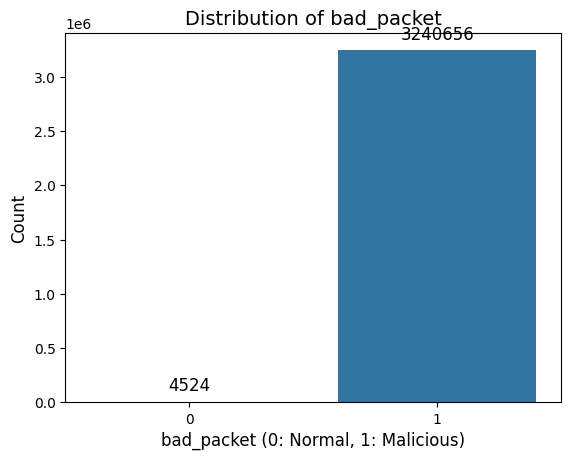

In [17]:
# Create the countplot
sns.countplot(x='bad_packet', data=df)

# Add count numbers above the bars
for p in plt.gca().patches:
    # Display count numbers as integers
    plt.text(p.get_x() + p.get_width() / 2.,  # X position
             p.get_height() + 0.02 * max([bar.get_height() for bar in plt.gca().patches]),  # Y position (a bit above the bar)
             f"{int(p.get_height())}",       # Display the height as text
             ha='center', va='bottom', fontsize=12)

plt.title("Distribution of bad_packet", fontsize=14)
plt.xlabel("bad_packet (0: Normal, 1: Malicious)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


Given your dataset with 3,240,656 rows labeled 1 (malicious packets) and 4,524 rows labeled 0 (normal packets), here's how you can handle the imbalance:

Strategy:

*   Upsample the Minority Class (Increase 0)
*   Downsample the Majority Class (Reduce 1)
*   Combined Approach (SMOTE or Hybrid)

In [18]:
# Count the number of unique protocols
unique_protocols_count = df['Protocol'].nunique()
print(f"Number of unique protocols: {unique_protocols_count}")

# Display the unique protocols
unique_protocols = df['Protocol'].unique()
print(f"Unique protocols: {unique_protocols}")
print(df.columns)

Number of unique protocols: 6
Unique protocols: ['ARP' 'ICMP' 'BROWSER' 'TLSv1.2' 'TCP' 'NBNS']
Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port',
       'Destination Port', 'bad_packet'],
      dtype='object')


***3.3. Code to Check Uniqueness***

****Unique in each column in dataset****

Knowing the amount of unique source and destination in the dataset is important to understand the size of the dataset



In [23]:
# Check the number of unique values in each column
columns_to_check = ['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port', 'Destination Port']
unique_counts = {col: df[col].nunique() for col in columns_to_check}

# Print the results
for column, count in unique_counts.items():
    print(f"{column}: {count} unique values")


Time: 3245180 unique values
Source: 29 unique values
Destination: 9 unique values
Protocol: 6 unique values
Length: 67 unique values
Source Port: 6 unique values
Destination Port: 6 unique values




****Analyze Protocol Distribution****



bad_packet     0        1
Protocol                 
ARP          241        0
BROWSER       47        0
ICMP         821  3240656
NBNS          53        0
TCP         2974        0
TLSv1.2      388        0


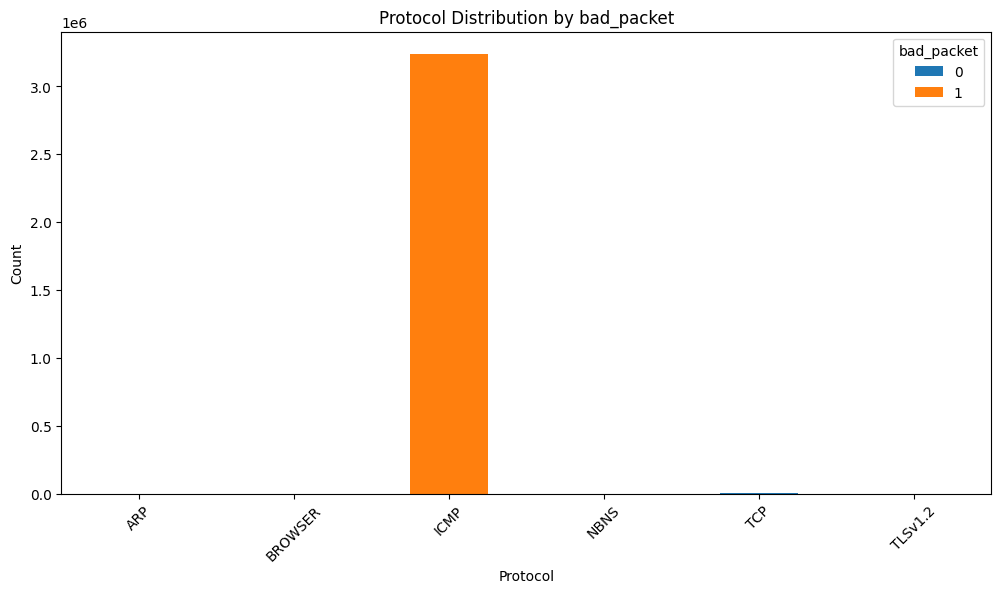

In [ ]:
# Count occurrences of each protocol grouped by bad_packet
protocol_distribution = df.groupby(['Protocol', 'bad_packet']).size().unstack(fill_value=0)
print(protocol_distribution)

# Visualize the distribution
import seaborn as sns
import matplotlib.pyplot as plt
protocol_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Protocol Distribution by bad_packet")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.legend(title="bad_packet")
plt.xticks(rotation=45)
plt.show()


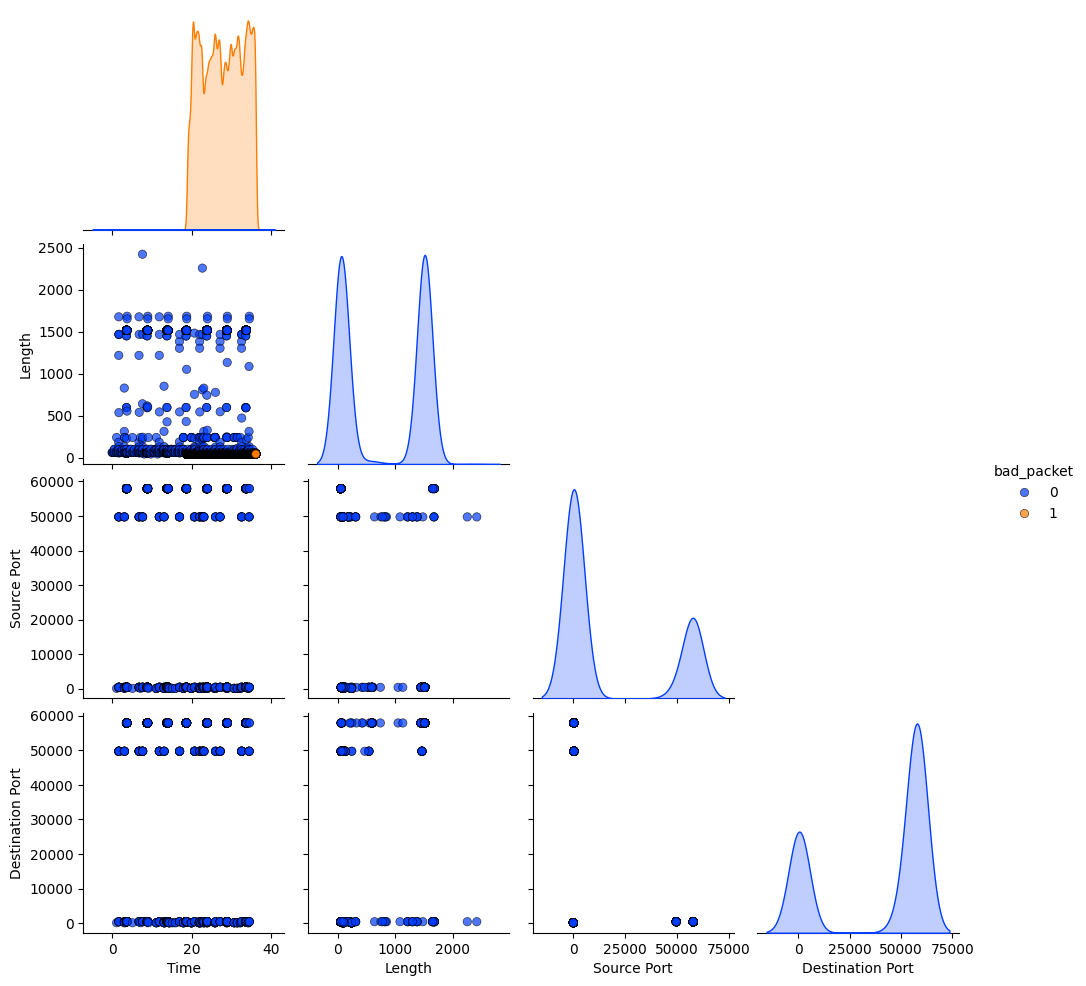

In [ ]:
# Convert pandas DataFrame to cuDF for GPU acceleration
train_df_cudf = cudf.DataFrame(df[['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Source Port', 'Destination Port', 'bad_packet']])

train_df = train_df_cudf.to_pandas()  # Convert back to pandas for Seaborn visualization

sns.pairplot(
    train_df,
    hue='bad_packet',
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.7, 'edgecolor': 'k', 'linewidth': 0.5},
    palette='bright'  # More vivid colors
)
plt.show()







****Remove useless columns****




In [ ]:
# Drop columns with too many missing values
columns_to_drop = ['Source Port', 'Destination Port']
train_df = train_df.drop(columns=columns_to_drop, axis=1)

print("Updated DataFrame:")
print(train_df.head())


Updated DataFrame:
       Time           Source Destination Protocol  Length  bad_packet
0  0.000000  VMware_8a:60:5f   Broadcast      ARP      60           0
1  0.081233  VMware_8a:12:84   Broadcast      ARP      60           0
2  0.217863  VMware_8a:7e:e9   Broadcast      ARP      60           0
3  0.419426  VMware_8a:b2:34   Broadcast      ARP      60           0
4  0.559886  VMware_8a:4e:1c   Broadcast      ARP      60           0




****Convert categorical columns into numerical format****

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Copy original DataFrame
df_processed = train_df.copy()

# Label Encoding for high-cardinality columns
label_encoders = {}
for col in ['Source', 'Destination']:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-Hot Encoding for low-cardinality columns
df_processed = pd.get_dummies(df_processed, columns=['Protocol'], drop_first=True)
print(df_processed.dtypes)


Time                float64
Source                int64
Destination           int64
Length                int64
bad_packet            int64
Protocol_BROWSER       bool
Protocol_ICMP          bool
Protocol_NBNS          bool
Protocol_TCP           bool
Protocol_TLSv1.2       bool
dtype: object


****Correlation heatmap****

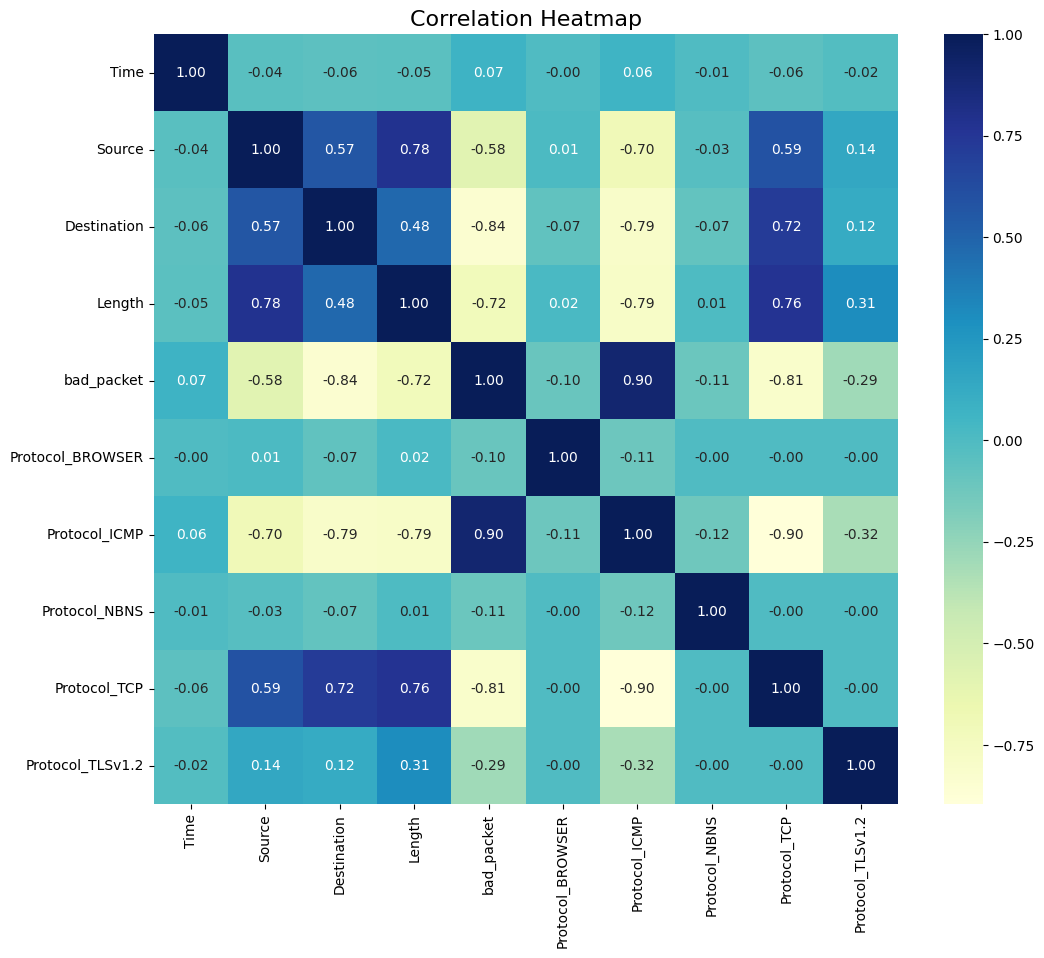

In [ ]:
# Correlation Matrix
corr = df_processed.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


### Time (3,245,180 unique values):
*   Every entry has a unique timestamp.
*   This feature is unlikely to be directly meaningful for the model in its raw form. So, I derive time-based patterns like cyclic features (sin/cos transformations) from it.

### Source (29 unique values):
*   Limited number of unique sources suggests that this is a categorical feature.
*   You can encode this feature using hash encoding, one-hot encoding, or label encoding.

### Destination (9 unique values):
*   categorical feature

### Protocol (6 unique values):
*   A small set of unique values indicating a strongly categorical feature.
*   One-hot encoding or label encoding could work well.

### Length (67 unique values):
*   A numerical feature with moderate variability.
*   It can be scaled (e.g., using normalization or standardization) to improve model **performance**.

### Source Port and Destination Port (6 unique values each):

*   Despite being numerical, the limited range indicates these might behave like categorical features.
*   You can group these into categories such as well-known ports, registered ports, or dynamic ports, or encode them as categorical features.


In [ ]:
print("Correlation with bad_packet:")
print(corr['bad_packet'].sort_values(ascending=False))

Correlation with bad_packet:
bad_packet          1.000000
Protocol_ICMP       0.904608
Time                0.067949
Protocol_BROWSER   -0.101856
Protocol_NBNS      -0.108163
Protocol_TLSv1.2   -0.292670
Source             -0.577653
Length             -0.717578
Protocol_TCP       -0.810598
Destination        -0.837708
Name: bad_packet, dtype: float64


***4. Dataset preparation***


In this section we prepare the dataset for the machine learning algorithms. We will split the dataset into training and testing sets, and we will also scale the data to make it more suitable for the algorithms.



****4.1. Splitting the training set**** **bold text**


In [ ]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df_processed.drop(columns=['bad_packet'])  # Features
y = df_processed['bad_packet']  # Target variable

# Split into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify the size of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")



Training set size: 2271626 samples
Test set size: 973554 samples


****4.1.1 Check if the datasets are balanced****


In [ ]:
# Check distribution of the target variable
print('Train set distribution:')
print(y_train.value_counts(normalize=True))

print('\nValidation set distribution:')
print(y_test.value_counts(normalize=True))


Train set distribution:
bad_packet
1    0.998601
0    0.001399
Name: proportion, dtype: float64

Validation set distribution:
bad_packet
1    0.998617
0    0.001383
Name: proportion, dtype: float64


****4.2. Data scaling****

Scaling the data is important to avoid that some features will have a bigger impact on the model training than others. This is especially important when we are dealing with features that have different units of measure.




In [ ]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_test_scaled = fitter.transform(X_test)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_test = pd.DataFrame(x_test_scaled, columns=X_test.columns)

print(df_feat_train.shape)

(2271626, 9)


***5. Feature Selection***

In this section we will use a Random Forest classifier to find the most important features in the dataset. This will help us to reduce the number of features used in the model training, and therefore speed up the training process.


5.1. ***Create model and fit it***


In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100) # 100 trees = default value

# Step 2: Train the Random Forest model
print("Training the Random Forest Classifier...")
rfc.fit(df_feat_train, y_train)

Training the Random Forest Classifier...


RandomForestClassifier()

5.2. ***Get feature importances***


In [ ]:
# Print features importance
feature_importances = pd.DataFrame(
    rfc.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
print(feature_importances)

                  importance
Length              0.492839
Destination         0.282081
Protocol_ICMP       0.111891
Protocol_TCP        0.067625
Source              0.030065
Time                0.013151
Protocol_TLSv1.2    0.002105
Protocol_BROWSER    0.000124
Protocol_NBNS       0.000118


5.3. ***Plot feature importances***


<Axes: xlabel='None', ylabel='importance'>

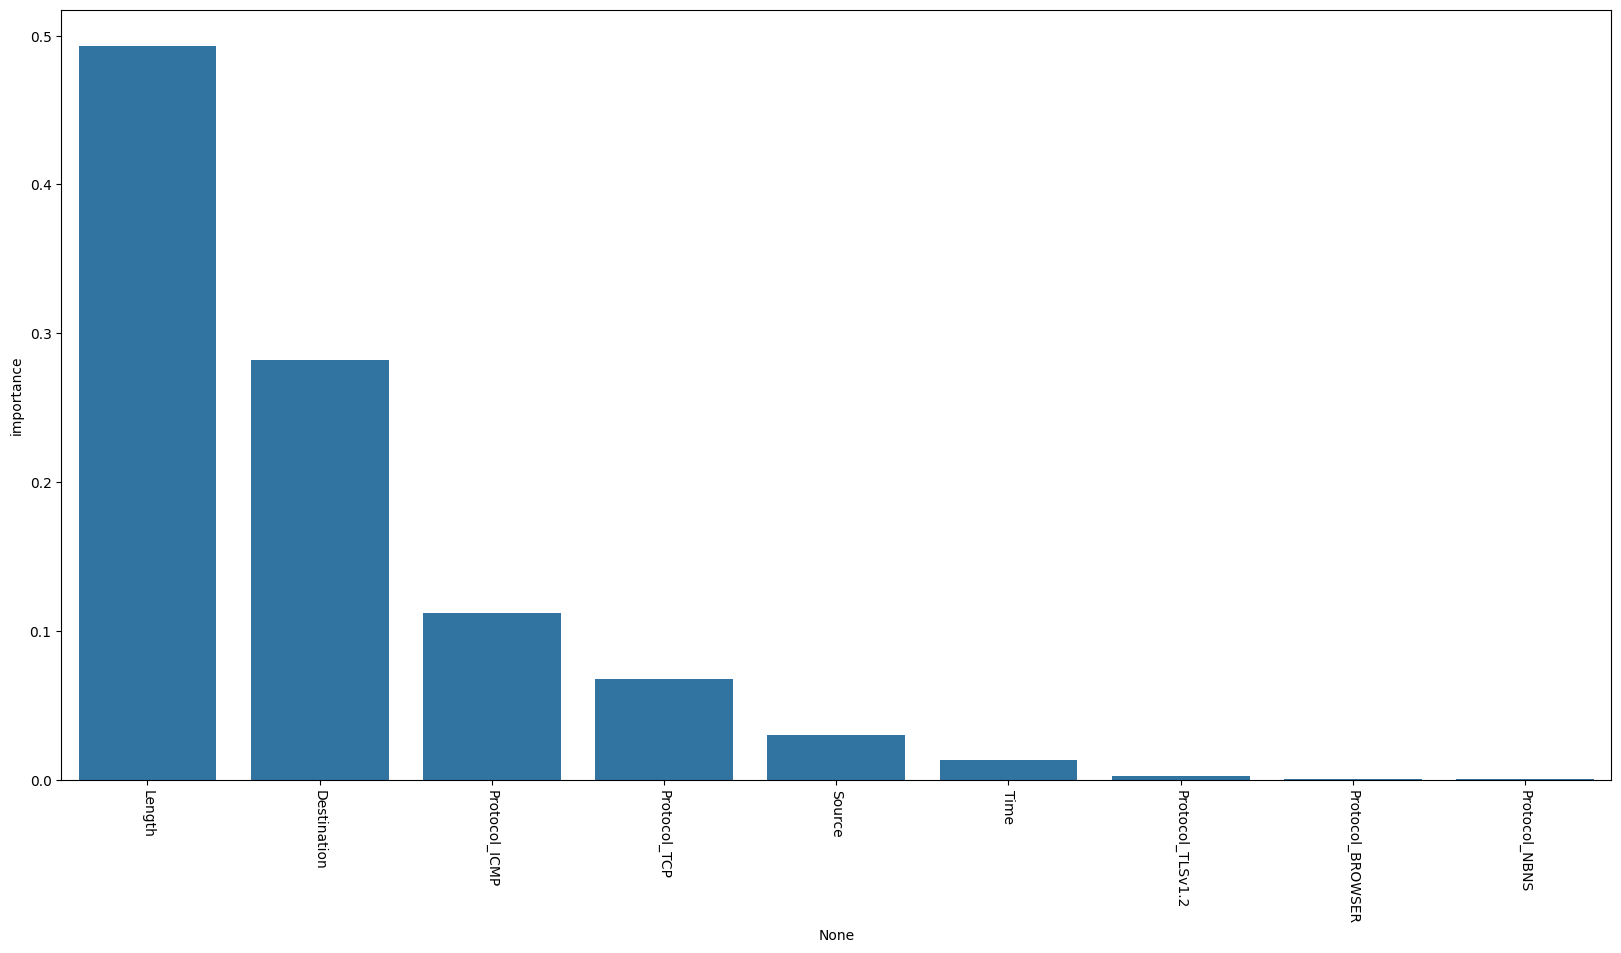

In [ ]:
# Plot feature importance
plt.figure(figsize=(20, 10))
plt.xticks(rotation=-90)
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])


5.4. ***Select most important features***

Select the most important features using the Random Forest classifier results




In [ ]:
MIN_IMPORTANCE_THRESHOLD = 0.02
# Select all columns with importance > 0.02
COLUMNS = feature_importances[feature_importances['importance'] > MIN_IMPORTANCE_THRESHOLD].index
COLUMNS

Index(['Length', 'Destination', 'Protocol_ICMP', 'Protocol_TCP', 'Source'], dtype='object')

5.5. ***Reprepare the dataset with the selected features***


In [ ]:
# Selected features from feature importance
selected_features = ['Length', 'Destination', 'Protocol_ICMP', 'Protocol_TCP', 'Source']

# Step 1: Filter the datasets to include only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test_selected)       # Transform on test set

# Convert scaled data back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train_selected.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test_selected.index)

# Verify the shapes of the scaled datasets
print("Scaled Training Data Shape:", X_train_scaled.shape)
print("Scaled Test Data Shape:", X_test_scaled.shape)

# Verify the first few rows
print("\nFirst few rows of scaled training data:")
print(X_train_scaled.head())

print("\nFirst few rows of scaled test data:")
print(X_test_scaled.head())

# Step 3: Ensure alignment with target labels
# Use y_train and y_test directly
print("\nTraining Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)

# Final datasets for modeling
print("Final Data Ready for Model Training and Evaluation")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)


Scaled Training Data Shape: (2271626, 5)
Scaled Test Data Shape: (973554, 5)

First few rows of scaled training data:
           Length  Destination  Protocol_ICMP  Protocol_TCP    Source
578945  -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2152375 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1861692 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1166120 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1742992 -0.026844     -0.03128        0.03372     -0.030193 -0.021747

First few rows of scaled test data:
           Length  Destination  Protocol_ICMP  Protocol_TCP    Source
2153741 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1978198 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2340429 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2868163 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
859188  -0.026844     -0.03128        0.03372     -0.030193 -0.021747

Trai

X_train_selected type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>
Fitting UMAP model with GPU...


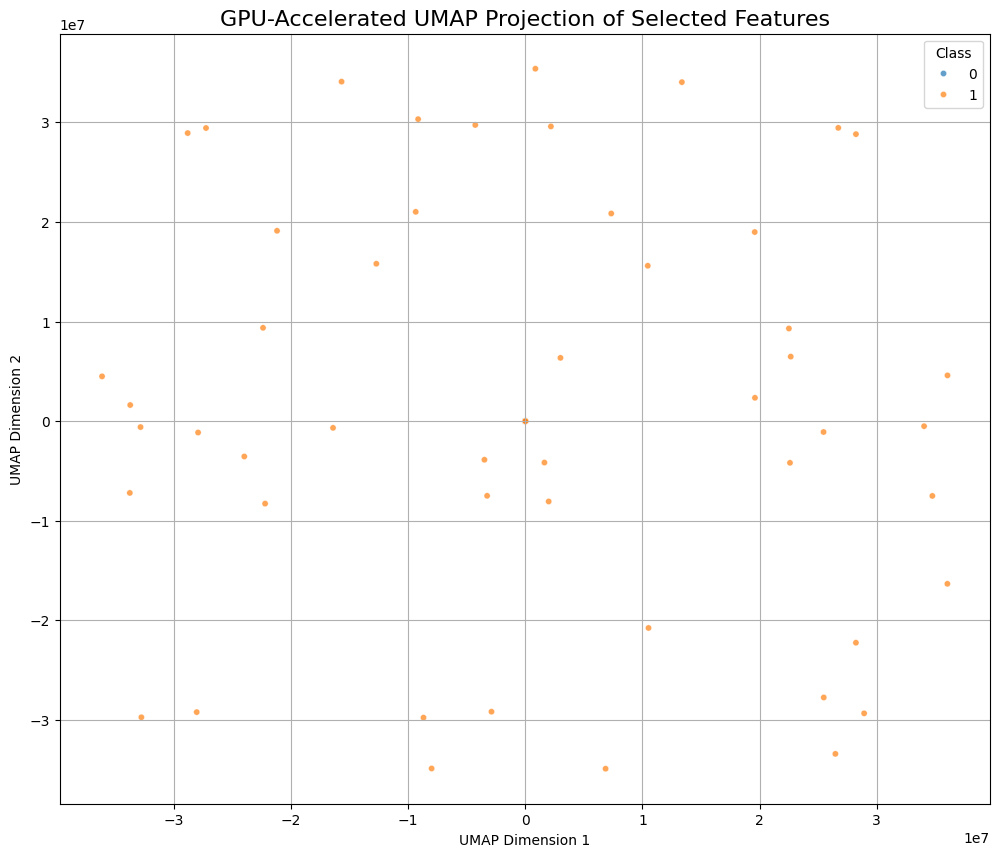

In [ ]:
# UMAP

print(f"X_train_selected type: {type(X_train_selected)}")
print(f"y_train type: {type(y_train)}")

# Convert to NumPy arrays if necessary
if isinstance(X_train_selected, pd.DataFrame):
    X_train_selected = X_train_selected.to_numpy()
if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy()

# Initialize cuML UMAP
reducer = UMAP(
    n_neighbors=50,  # Adjust neighbors for local/global balance
    min_dist=0.3,    # Adjust for cluster spread
    random_state=42  # For reproducibility
)

# Fit UMAP model
print("Fitting UMAP model with GPU...")
embedding = reducer.fit_transform(X_train_selected)

# Plot the UMAP embedding
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train,       # Target labels for coloring
    palette='tab10',   # Choose a color palette
    alpha=0.7,
    s=20               # Size of points
)

plt.title("GPU-Accelerated UMAP Projection of Selected Features", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Class", fontsize=10, loc="best")
plt.grid(True)
plt.show()


For Decision Tree:
Use the dataset as it is (no further feature selection needed).
For kNN and Naive Bayes:
Perform Feature Selection:

Use a model-based method (e.g., Random Forest) to identify and retain important features.
Alternatively, use Recursive Feature Elimination (RFE).
Scale Features (Important for kNN):

Scaling is essential for kNN since it relies on distance metrics.
You've already applied StandardScaler, so you’re good to go.


verivy feature selection

In [ ]:
print("Scaled Training Data Shape:", X_train_scaled.shape)
print("Scaled Test Data Shape:", X_test_scaled.shape)

print("\nFirst few rows of scaled training data:")
print(X_train_scaled.head())

print("\nFirst few rows of scaled test data:")
print(X_test_scaled.head())


print("\nTraining Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)


print("Final Data Ready for Model Training and Evaluation")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)

Scaled Training Data Shape: (2271626, 5)
Scaled Test Data Shape: (973554, 5)

First few rows of scaled training data:
           Length  Destination  Protocol_ICMP  Protocol_TCP    Source
578945  -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2152375 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1861692 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1166120 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1742992 -0.026844     -0.03128        0.03372     -0.030193 -0.021747

First few rows of scaled test data:
           Length  Destination  Protocol_ICMP  Protocol_TCP    Source
2153741 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1978198 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2340429 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2868163 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
859188  -0.026844     -0.03128        0.03372     -0.030193 -0.021747

Trai

***6. Model Training***
In this section we will train different models and compare their results. We will use the following models:

K-Nearest Neighbors (KNN)
SVC
Random Forest Classifier


***6.1. K-Nearest Neighbors (kNN)***

***6.1.1 Finding the best K hyperparameter for KNN***


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git


fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
import cudf
print("RAPIDS cuDF version:", cudf.__version__)

Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com

        ***********************************************************************
        The pip install of RAPIDS is complete.
        
        Please do not run any further installation from the conda based installation methods, as they may cause issues!
        
        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files. 
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        


In [ ]:
import cudf
print("RAPIDS cuDF version:", cudf.__version__)


RAPIDS cuDF version: 24.10.01


***6.1.2. Fit model with best K hyperparameter + make predictions***


Training and testing for k=1...
Test Accuracy for k=1: 1.0000
Training and testing for k=2...
Test Accuracy for k=2: 1.0000
Training and testing for k=3...
Test Accuracy for k=3: 1.0000
Training and testing for k=4...
Test Accuracy for k=4: 1.0000
Training and testing for k=5...
Test Accuracy for k=5: 1.0000
Training and testing for k=6...
Test Accuracy for k=6: 1.0000
Training and testing for k=7...
Test Accuracy for k=7: 1.0000
Training and testing for k=8...
Test Accuracy for k=8: 1.0000
Training and testing for k=9...
Test Accuracy for k=9: 1.0000
Training and testing for k=10...
Test Accuracy for k=10: 1.0000
Training and testing for k=11...
Test Accuracy for k=11: 1.0000
Training and testing for k=12...
Test Accuracy for k=12: 1.0000
Training and testing for k=13...
Test Accuracy for k=13: 1.0000
Training and testing for k=14...
Test Accuracy for k=14: 1.0000
Training and testing for k=15...
Test Accuracy for k=15: 1.0000
Training and testing for k=16...
Test Accuracy for k=16: 1

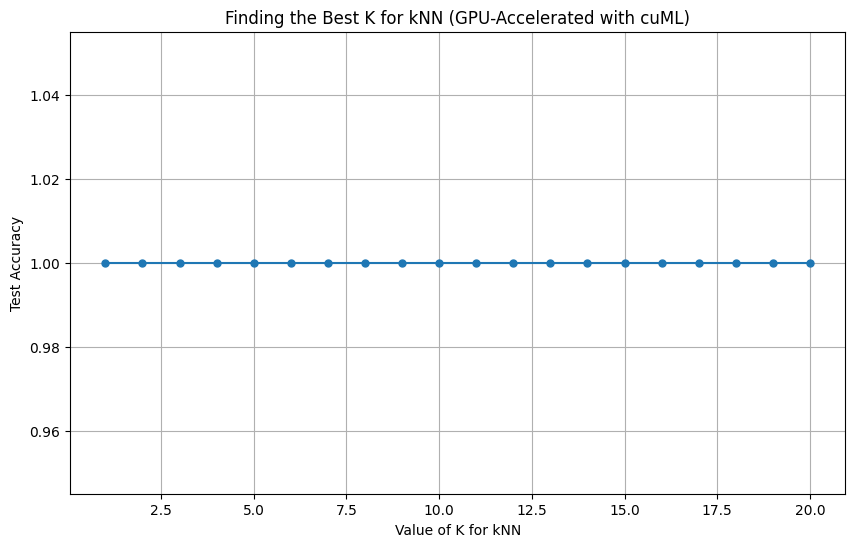

Best k: 1
Best accuracy: 1.0000

Classification Report for Best K:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1346
           1       1.00      1.00      1.00    972208

    accuracy                           1.00    973554
   macro avg       1.00      1.00      1.00    973554
weighted avg       1.00      1.00      1.00    973554



In [ ]:
from cuml.manifold import UMAP
from cuml.neighbors import KNeighborsClassifier as cuMLKNN
from sklearn.metrics import accuracy_score, classification_report

# Ensure your data is ready for training
# Use the NumPy arrays directly
X_train_full = X_train_scaled
y_train_full = y_train
X_test_full = X_test_scaled
y_test_full = y_test


MAX_K = 20  # Adjust the range as needed
k_range = list(range(1, MAX_K + 1))

results = {}

for k in k_range:
    print(f"Training and testing for k={k}...")

    # Initialize cuML kNN
    knn = cuMLKNN(n_neighbors=k, algorithm='auto')

    # Train on the full dataset
    knn.fit(X_train_full, y_train_full)

    # Predict on the test set
    y_pred = knn.predict(X_test_full)

    # Evaluate test accuracy
    test_accuracy = accuracy_score(y_test_full, y_pred)
    results[k] = test_accuracy
    print(f"Test Accuracy for k={k}: {test_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, list(results.values()), marker='o', linestyle='-', markersize=5)
plt.xlabel('Value of K for kNN')
plt.ylabel('Test Accuracy')
plt.title('Finding the Best K for kNN (GPU-Accelerated with cuML)')
plt.grid()
plt.show()

best_k = max(results, key=results.get)
print(f"Best k: {best_k}")
print(f"Best accuracy: {results[best_k]:.4f}")

final_knn = cuMLKNN(n_neighbors=best_k, algorithm='auto')
final_knn.fit(X_train_full, y_train_full)

y_pred_final = final_knn.predict(X_test_full)
print("\nClassification Report for Best K:")
print(classification_report(y_test_full, y_pred_final))


In [ ]:
print("Scaled Training Data Shape:", X_train_scaled.shape)
print("Scaled Test Data Shape:", X_test_scaled.shape)

print("\nFirst few rows of scaled training data:")
print(X_train_scaled.head())

print("\nFirst few rows of scaled test data:")
print(X_test_scaled.head())

print("\nTraining Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)

print("Final Data Ready for Model Training and Evaluation")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)

Scaled Training Data Shape: (2271626, 5)
Scaled Test Data Shape: (973554, 5)

First few rows of scaled training data:
           Length  Destination  Protocol_ICMP  Protocol_TCP    Source
578945  -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2152375 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1861692 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1166120 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1742992 -0.026844     -0.03128        0.03372     -0.030193 -0.021747

First few rows of scaled test data:
           Length  Destination  Protocol_ICMP  Protocol_TCP    Source
2153741 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
1978198 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2340429 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
2868163 -0.026844     -0.03128        0.03372     -0.030193 -0.021747
859188  -0.026844     -0.03128        0.03372     -0.030193 -0.021747

Trai

***7.1. Support Vector Machine Classifier (SVC) training***


In [ ]:
from cuml.svm import SVC as cuMLSVC


# Ensure your data is ready for training
# Use the NumPy arrays directly
X_train_full = X_train_scaled
y_train_full = y_train
X_test_full = X_test_scaled
y_test_full = y_test

# Initialize cuML SVM with RBF kernel
svm_model = cuMLSVC(kernel='rbf', random_state=42)

print("Training the SVM model...")
svm_model.fit(X_train_full, y_train_full)

print("Predicting with SVM...")
y_pred_svm = svm_model.predict(X_test_full)

print("\nSVM Classification Report:")
print(classification_report(y_test_full, y_pred_svm))




Training the SVM model...
Predicting with SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1346
           1       1.00      1.00      1.00    972208

    accuracy                           1.00    973554
   macro avg       1.00      1.00      1.00    973554
weighted avg       1.00      1.00      1.00    973554



***7.2 Random Forest Classifier***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("Training the Random Forest model...")
rf_model.fit(X_train_selected, y_train)

print("Predicting on the test set...")
y_pred_rf = rf_model.predict(X_test_selected)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Training the Random Forest model...
Predicting on the test set...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1346
           1       1.00      1.00      1.00    972208

    accuracy                           1.00    973554
   macro avg       1.00      1.00      1.00    973554
weighted avg       1.00      1.00      1.00    973554



***8 Examin the source of all malicious and normal source of my data***

Based on the code and the results below, it appears that all malicious activity originates from a single source, while all other sources show no malicious activity. Consequently, the ML model understands that the only source of malicious activity is the IP address 192.167.5.35, while the other 28 sources have no malicious messages.

Source
192.167.5.35    3240656
Name: count, dtype: int64
Source
192.232.16.204     2235
192.167.5.35       1034
192.167.5.22        786
142.251.32.14       128
VMware_8a:7e:e9      36
VMware_8a:12:84      35
VMware_8a:60:5f      35
VMware_8a:31:5e      35
VMware_8a:4e:1c      35
VMware_8a:b2:34      35
192.167.1.235        12
VMware_8a:25:c0      10
192.167.4.164         9
192.167.6.52          9
192.167.9.41          9
192.167.9.105         9
192.167.7.108         9
192.167.5.247         9
192.167.9.39          9
VMware_8a:9d:21       7
192.167.2.126         6
192.167.3.73          6
192.167.4.188         6
192.167.9.21          5
VMware_8a:0a:66       4
VMware_8a:7f:3f       4
VMware_8a:aa:27       3
VMware_8a:5c:e6       2
Name: count, dtype: int64


<Axes: title={'center': 'Top 10 Malicious Source IP Addresses'}, xlabel='Source IP Address', ylabel='Count'>

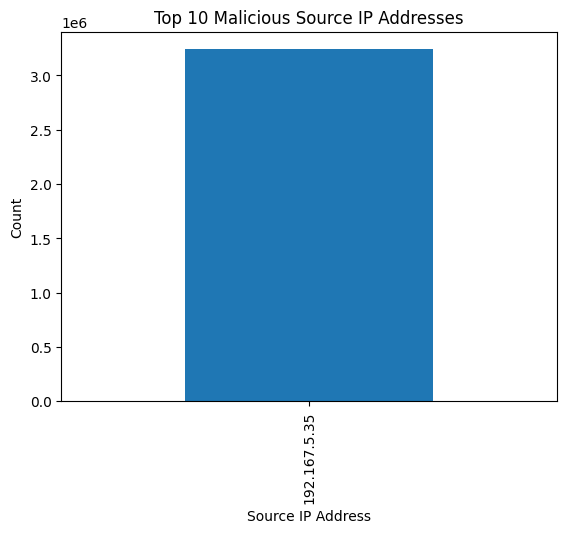

In [22]:
# Load your dataset
df = pd.read_csv('/content/sample_data/NandakumarMenonAdvait_MT_S2.csv')

# Filter for malicious activities
malicious_df = df[df['bad_packet'] == 1]
normal_df = df[df['bad_packet'] == 0]

# Group by Source IP and count occurrences
ip_counts = malicious_df['Source'].value_counts()
ip_count = normal_df['Source'].value_counts()

# Display top offenders
print(ip_counts.head(10))  # Top 10 Source IP addresses with the most malicious activity
print(ip_count.head(28))  # Top 10 Source IP addresses with the most malicious activity

# Optionally, visualize using a bar chart
ip_counts.head(10).plot(kind='bar', title="Top 10 Malicious Source IP Addresses", xlabel="Source IP Address", ylabel="Count")
